# Hate Speech Classification with a Long-Short Term Memory Model

This notebook utilises a Long-Short Term Memory (LSTM) model to determine if a tweet is `hateful` or `not hateful`.
<br>
<br>
A LSTM model is an improvement on the traditional RNN architecture, able to capture long-term dependencies in sequences by maintaining a constant representation of the features while adding or removing elements from it. The module is able to retain information longer than the solely sequential  method of a RNN and curb vanishing/exploding gradients.

## Imports

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import json
import matplotlib.pyplot as plt
from os.path import exists

import torch
import torch.optim as optim
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import wandb

# custom modules
import preprocess
from model_details import print_model_details
from model_details import num_params
from lstm_model import LSTM_Model
import dataloader_helpers as dh

## Data PreProcessing

This cell is used to standardise and reduce datasets to `label` and `text` columns. 
<br>
They are then concatenated to form one large dataset.

Data sources:
- https://kaggle.com/datasets/kazanova/
- https://hasocfire.github.io/hasoc/2021/dataset.html
- https://figshare.com/articles/dataset/Labelled_Hate_Speech_Detection_Dataset_/19686954
- https://zenodo.org/record/3706866
- https://kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset
- https://kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [12]:
df = pd.read_csv(
    'Data/Unprocessed/training.1600000.processed.noemoticon.csv', 
    encoding='latin', 
    header=None
    )
df.columns = ['label', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(columns=['id', 'date', 'query', 'user_id'])

df['label'].mask(df['label'] == 0, 1, inplace=True)
df['label'].mask(df['label'] == 2, 0, inplace=True)
df['label'].mask(df['label'] == 4, 0, inplace=True)

df_2 = pd.read_csv(
    'Data/Unprocessed/hasoc_english_dataset.tsv', 
    delimiter='\t'
    )
df_2 = df_2.drop(columns=['text_id', 'task_1', 'task_3'])
df_2 = df_2.rename(columns={'task_2': 'label'})

df_2['label'].mask(df_2['label'] == 'HATE', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'OFFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'PRFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'NONE', 0, inplace=True)

df_3 = pd.read_csv('Data/Unprocessed/HateSpeechDetection.csv')
df_3 = df_3.drop(columns=['Platform'])
df_3 = df_3.rename(columns={'Comment': 'text'})
df_3 = df_3.rename(columns={'Hateful': 'label'})

df_4 = pd.read_csv(
    'Data/Unprocessed/hatespeech_text_label_vote_RESTRICTED_100K.csv'
    )
df_4 = df_4.drop(columns=['Votes for the majority label'])
df_4 = df_4.rename(columns={'Tweet text': 'text'})
df_4 = df_4.rename(columns={'Label': 'label'})

df_4['label'].mask(df_4['label'] == 'normal', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'spam', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'abusive', 1, inplace=True)
df_4['label'].mask(df_4['label'] == 'hateful', 1, inplace=True)
df_4['text'] = df_4['text'].str.replace('RT', '')

df_5 = pd.read_csv('Data/Unprocessed/FinalBalancedDataset.csv')
df_5.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df_5.drop(["a"], axis=1, inplace=True)
df_5 = df_5.rename(columns={'Toxicity': 'label'})
df_5 = df_5.rename(columns={'tweet': 'text'})
df_5['text'] = df_5['text'].str.replace('ð', '')

df_6 = pd.read_csv('Data/Unprocessed/Reddit_Data.csv')
df_6 = df_6.rename(columns={'clean_comment': 'text'})
df_6 = df_6.rename(columns={'category': 'label'})
df_6.drop(df_6[df_6['label'] == 0].index, inplace=True)
df_6 = df_6[df_6['text'] != '']
df_6['label'].mask(df_6['label'] == 1, 0, inplace=True)
df_6['label'].mask(df_6['label'] == -1, 1, inplace=True)

"""
Concatenate datasets
"""

processed_data = pd.concat([df, df_2, df_3, df_4, df_5, df_6])

processed_data['text'] = processed_data['text'].str.replace('https', '')
processed_data['text'] = processed_data['text'].str.replace('t', '')
processed_data['text'] = processed_data['text'].str.replace('co', '')
processed_data['text'] = processed_data['text'].str.replace('amp', '')
processed_data['text'] = processed_data['text'].str.replace('quo', '')

# save all data
processed_data.to_csv('Data/processed_data.csv')
print("{:,} elements".format(len(processed_data)))
processed_data.head()

1,789,694 elements


,label,text
0,1,"@swichfoo hp://wipic.m/2y1zl - Awww, ha's a bu..."
1,1,is upse ha he can' updae his Facebook by exing...
2,1,@Kenichan I dived many imes for he ball. Manag...
3,1,my whole body feels ichy and like is on fire
4,1,"@naionwideclass no, i's no behaving a all. i'm..."


## Word Clouds

(-0.5, 399.5, 299.5, -0.5)

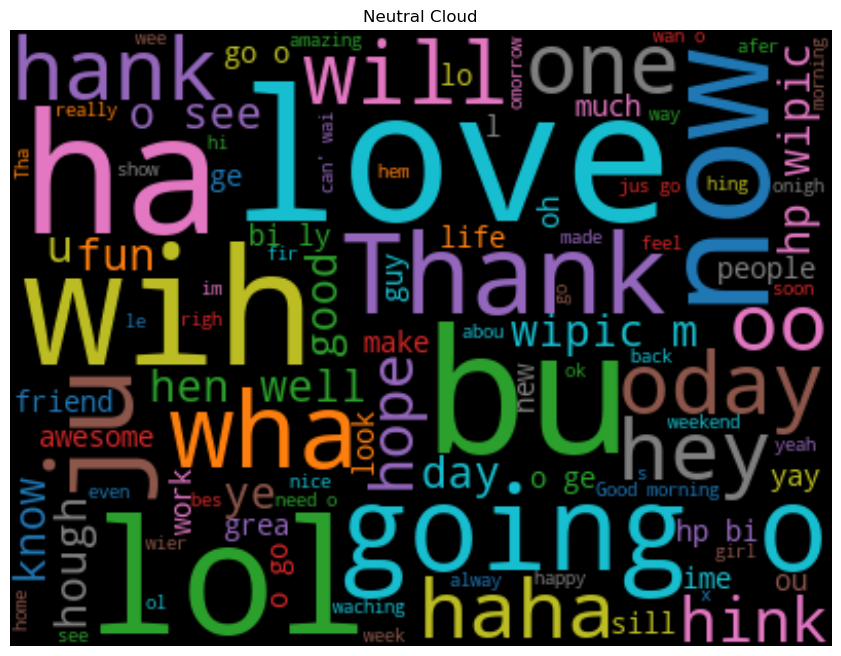

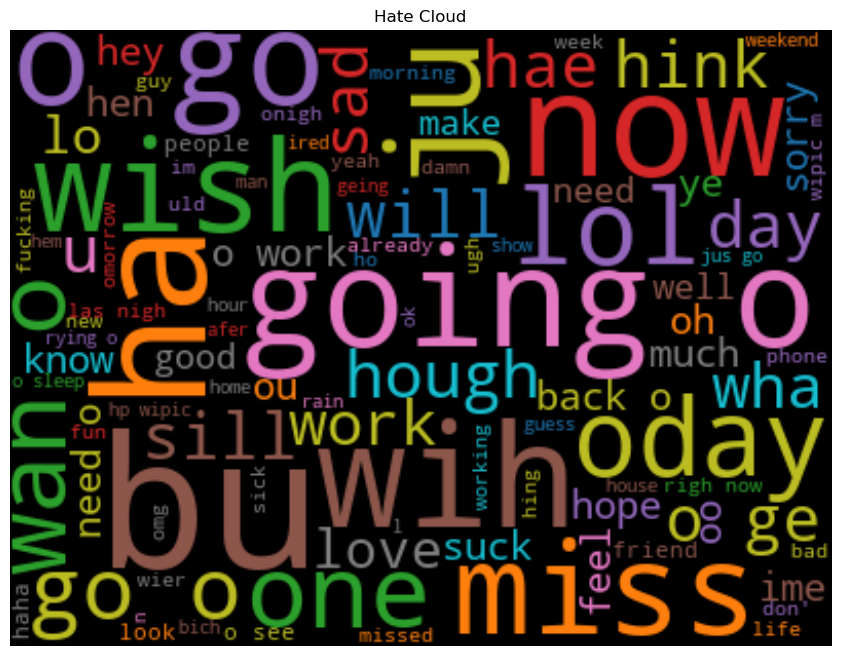

In [13]:
neutral_words = ' '.join([
    word for word in processed_data['text'][processed_data['label'] == 0]
    ])

neutral_cloud = WordCloud(background_color='black', 
                          colormap='tab10', 
                          contour_width=2, 
                          contour_color='white', 
                          width=400, 
                          height=300, 
                          max_font_size=90, 
                          max_words=100).generate(neutral_words)

plt.figure(figsize=(12, 8))
plt.imshow(neutral_cloud, interpolation='bilinear')
plt.title('Neutral Cloud')
plt.axis('off')

hate_words = ' '.join([
    word for word in processed_data['text'][processed_data['label'] == 1]
    ])

hate_cloud = WordCloud(background_color='black', 
                          colormap='tab10', 
                          contour_width=2, 
                          contour_color='white', 
                          width=400, 
                          height=300, 
                          max_font_size=90, 
                          max_words=100).generate(hate_words)

plt.figure(figsize=(12, 8))
plt.imshow(hate_cloud, interpolation='bilinear')
plt.title('Hate Cloud')
plt.axis('off')

## Create Subsets

The total dataset is very large, containing 1,789,694 items.
<br>
The dataset is split into subsets, each composed of a training, validation and test set. By treating these subsets as independent datasets, the model can be trained periodically.

In [2]:
def train_val_test_split(data):
    """
    Splits a dataset into train/val/test sets.
    
    - 81% Training data
    - 9% Validation data
    - 10% Testing data

    Args:
        data (DataFrame): DataFrame which needs splitting.

    Returns:
        train_data, val_data, test_data 
            (DataFrame, DataFrame, DataFrame): train/va/test sets.
    """
    train_data_ = data.sample(frac=0.9)
    test_data = data.drop(train_data_.index)
    train_data = train_data_.sample(frac=0.9)
    val_data = train_data_.drop(train_data.index)
    return train_data, val_data, test_data

def dataset_details(dataset, data_name, set_name):
    """
    Displays the number of elements each class has in the dataset.

    Args:
        dataset (DataFrame): 
        data_name (str): Name of the folder e.g. 'data_1'
        set_name (str): Name of the dataset (e.g. 'Training').
    """
    num_samples = len(dataset)
    num_label_0 = Counter(dataset['label'].tolist())[0]
    num_label_1 = Counter(dataset['label'].tolist())[1]
    split_percent = num_label_1 / num_samples * 100
    print('*' + '-' * 19 + '*')
    print(f'|      {data_name:11}  |')
    print(f'|     {set_name:11}   |')
    print('|' + '-' * 19 + '|')
    print(f'| Samples : {num_samples:7} |')
    print('*' + '-' * 19 + '*')
    print(f'| Neutral : {num_label_0:6}  |')
    print(f'| Hate    : {num_label_1:6}  |')
    print(f'| Split   : {split_percent:.2f}%  |')
    print('*' + '-' * 19 + '*')
    if set_name == 'Testing':
        print('\n\n')

In [15]:
# Shuffle dataframe
processed_data = processed_data.sample(frac=1)
# Split dataframe into subsets
num_subsets = 16
split_data = np.array_split(processed_data, num_subsets)
# List of subset names
data_names = ['data_1', 'data_2', 'data_3', 'data_4', 'data_5', 
    'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_11',
    'data_12', 'data_13', 'data_14', 'data_15', 'data_16']

"""
Iterates through the subsets and saves them to disk
Creates a training, validation and test set from each subset
Displays the label splits and saves each dataset to disk
"""
for i in range(len(split_data)):
    # reset indexes of each subset and save to disk
    split_data[i].reset_index(drop=True, inplace=True)
    split_data[i].to_csv(f'Data/Split Datasets/{data_names[i]}.csv')

    # Split subset into training, validation and test sets and save
    train, val, test = train_val_test_split(split_data[i])
    dataset_details(train, data_name=data_names[i], set_name='Training')
    dataset_details(val, data_name=data_names[i], set_name='Validation')
    dataset_details(test, data_name=data_names[i], set_name='Testing')
    train.to_csv(f'Data/Split Datasets/{data_names[i]}/train.csv')
    val.to_csv(f'Data/Split Datasets/{data_names[i]}/val.csv')
    test.to_csv(f'Data/Split Datasets/{data_names[i]}/test.csv')

*-------------------*
|      data_1       |
|     Training      |
|-------------------|
| Samples :   90603 |
*-------------------*
| Neutral :  46741  |
| Hate    :  43862  |
| Split   : 48.41%  |
*-------------------*
*-------------------*
|      data_1       |
|     Validation    |
|-------------------|
| Samples :   10067 |
*-------------------*
| Neutral :   5109  |
| Hate    :   4958  |
| Split   : 49.25%  |
*-------------------*
*-------------------*
|      data_1       |
|     Testing       |
|-------------------|
| Samples :   11186 |
*-------------------*
| Neutral :   5727  |
| Hate    :   5459  |
| Split   : 48.80%  |
*-------------------*



*-------------------*
|      data_2       |
|     Training      |
|-------------------|
| Samples :   90603 |
*-------------------*
| Neutral :  46751  |
| Hate    :  43852  |
| Split   : 48.40%  |
*-------------------*
*-------------------*
|      data_2       |
|     Validation    |
|-------------------|
| Samples :   10067 |
*------

## Build Vocabulary

A vocabulary is built by counting the occurences of words in the entire dataset and mapping them to the number of occurences.

In [2]:
def build_vocab(data, max_size=30000):
    """
    The vocab is a str->int mapping of each word.
    - Uses a Counter object to count occurences of words.
    - Maps the word to the number of occurences.
    Checks if a vocabulary exists before creating a new one.

    Args:
        data (np.array): Dataset containing all words.
        max_size (int, optional): Maximum size of vocab. (default=30000)

    Returns:
        v (Vocab): Vocabulary object of max_size words
    """
    if exists('Data/vocab.json'):
        # if vocab exists, load vocab
        with open('Data/vocab.json', 'r') as f:
            vocab_ = json.load(f)
        v = Vocab(vocab_)
    else:
        # else build vocab
        tokenizer = get_tokenizer('basic_english')
        counter = Counter()
        for(label, text) in data:
            counter.update(tokenizer(text))
        most_common = counter.most_common(max_size)
        counter = Counter(dict(most_common))
        v = Vocab(counter)
        # Save vocab so it can be used for subsequent training runs
        with open('Data/vocab.json', 'w') as f:
            json.dump(v.stoi, f)
    return v

# Load dataset
processed_data = pd.read_csv(
    'Data/processed_data.csv'
    ).drop(columns=['Unnamed: 0'])

processed_data = processed_data.to_numpy()

vocab = build_vocab(processed_data)
data_pipeline = preprocess.PreprocessingPipeline(vocab)

## Run Model

In [3]:
def set_device():
    """
    Device used to process tensors.
    """
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            return torch.device("mps")
    else:
        raise ValueError('Train with MPS device\n')

# ! These parameters must be the same when loading a model

vocab_len = len(vocab)

dimensions = 75
# Number of nodes in the LSTM module
hidden_nodes = 4
# Number of layers in the LSTM module
hidden_layers = 3
# Size of batches 
batch_size = 128
# Set device used to process tensors
device = set_device()

# Initialise DataLoaders
train_loader, val_loader, test_loader = dh.init_dataloaders(
    folder='data_1',
    batch_size=batch_size,
    pipeline=data_pipeline,
    device=device
    )

lstm = LSTM_Model(
    vocab_size=vocab_len,
    vector_dim=dimensions, 
    num_hidden_nodes=hidden_nodes, 
    hidden_layers=hidden_layers
    ).to(device)

learning_rate = 0.01
# Loss function
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=20)

print_model_details(lstm)

2,260,622 weights.
745 biases.
2,261,367 total parameters.


In [4]:
# Toggle tracking with wandb
track = True

if track:
    wandb.init(
    project = "hate-speech-classification",
    config = {
        "Learning Rate": learning_rate,
        "Trainable parameters": num_params(lstm),
        "Step Size": 20
    })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anthonygavriel. Use `wandb login --relogin` to force relogin


In [5]:
epochs = 40

t_acc, t_loss, v_acc, v_loss = lstm.run_training(
    train_loader, 
    val_loader, 
    test_loader, 
    lstm, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True,
    wandb_track=track
    )

-------------------------------------------------
|		     Epoch 1      		|
-------------------------------------------------
|   177 /   708 batches | 55.71014747% accurate |
|   354 /   708 batches | 60.94190141% accurate |
|   531 /   708 batches | 63.96117246% accurate |
-------------------------------------------------
| Validation Accuracy   : 71.60799051% accurate |
-------------------------------------------------
| Time Elapsed		: 35.71 seconds		|
-------------------------------------------------

-------------------------------------------------
|		     Epoch 2      		|
-------------------------------------------------
|   177 /   708 batches | 75.61446629% accurate |
|   354 /   708 batches | 75.38512324% accurate |
|   531 /   708 batches | 75.49195254% accurate |
-------------------------------------------------
| Validation Accuracy   : 75.13844937% accurate |
-------------------------------------------------
| Time Elapsed		: 29.06 seconds		|
-----------------------------

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Learning Rate,███████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
Training Accuracy,▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
Training Loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▂█▇▃▃▄▄▂▃▅▇▅▃▂▄▄▃▂▂▁▄▃▂▄▃▃▃▃▃▃▄▄▃▄▄▅▄▄▃▄
Validation Loss,▄▁▁▂▄▄▄▄▅▄▃▅▅▆▆▅▄▅█▆▆▇▇▆▆▇▅▆▆▇▆▆▅▆▅▅▆▆▇▅
Epoch,39
Learning Rate,0.0001
Training Accuracy,80.04281
Training Loss,0.00331
Validation Accuracy,72.75514


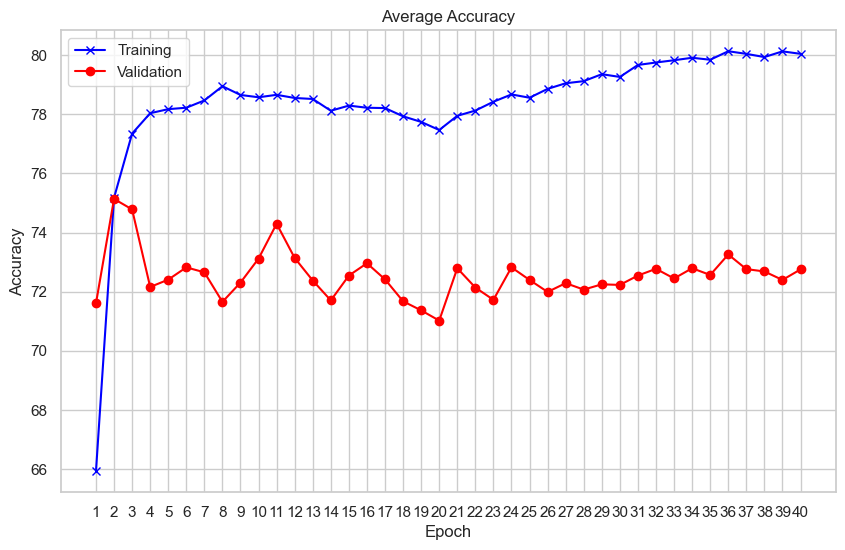

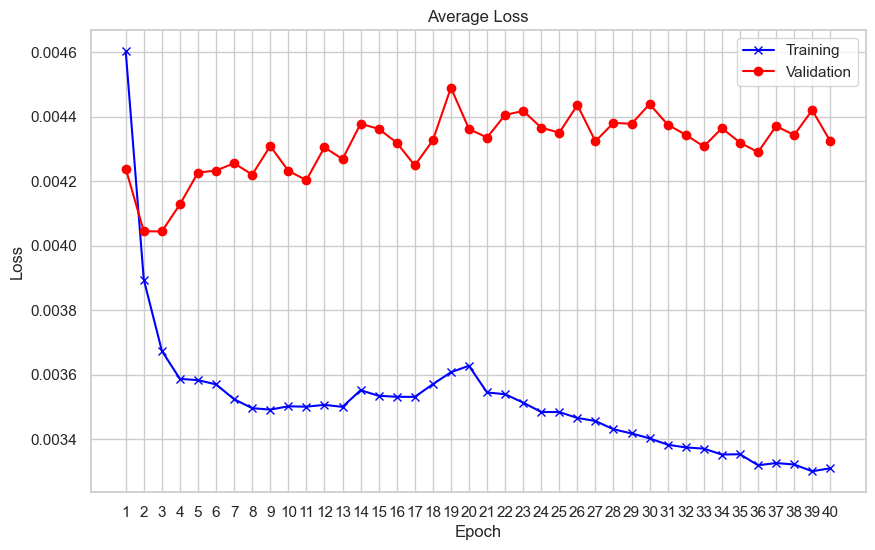

In [6]:
from model_details import plot_metrics

plot_metrics(t_acc, v_acc, 'Accuracy')
plot_metrics(t_loss, v_loss, 'Loss')

## Save Model

Saves the model and its state dictionary at a checkpoint. This allows the model to continue training in the future.

In [8]:
def save_model(model, model_optimizer):
    """
    Saves the model and optimizer state dictionaries.
    The model `state_dict` contains all learnable parameters of the model.
    The optimizer `state_dict` contains information about the optimizer.
        This allows the model to pause and resume training.
    Args:
        model (nn.Module): The LSTM model being loaded.
        model_optimizer (torch.optim.Adam): Backpropagation method.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': model_optimizer.state_dict(),
    }, 'checkpoint.pth')

save_model(lstm, optimizer)

## Load the Model

Load the model to resume training or make predictions.

In [12]:
import torch
import json
import preprocess
from lstm_model import LSTM_Model
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader
from torch import nn
import time
from torchtext.vocab import Vocab
import torch.nn.utils.rnn as rnn_utils
from model_details import print_model_details
from os.path import exists
import dataloader_helpers as dh

In [6]:
def load_vocab():
    if exists('Data/vocab.json'):
        # if vocab exists, load vocab
        with open('Data/vocab.json', 'r') as f:
            vocab_ = json.load(f)
            vocab = Vocab(vocab_)
            return vocab
    else:   
        raise FileNotFoundError('No vocabulary')

def load_model():
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            device = torch.device("mps")
            # ! These parameters must be the same as the saved model
            vocab_len = len(vocab)
            # Data dimensionality
            dimensions = 75
            # Number of nodes in the LSTM module
            hidden_nodes = 4
            # Number of layers in the LSTM module
            hidden_layers = 3
            lstm = LSTM_Model(
                vocab_size=vocab_len,
                vector_dim=dimensions, 
                num_hidden_nodes=hidden_nodes, 
                hidden_layers=hidden_layers
                ).to(device)
            return lstm, device
    else:
        raise ValueError('Model cannot train without MPS device\n')

vocab = load_vocab()
data_pipeline = preprocess.PreprocessingPipeline(vocab)
loaded_model, device = load_model()

print_model_details(loaded_model)

2,270,742 weights.
1,105 biases.
2,271,847 total parameters.


## Resume Training

In [13]:
epochs = 5
batch_size = 128
learning_rate = 0.01
# Loss function
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(loaded_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=5)



checkpoint = torch.load('checkpoint.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

"""
Model has currently been trained on:
☑ data_1
☐ data_2
...
☐ data_16
"""
# * Ensure this is the correct folder before training
data_folder = 'data_2'

train_loader, val_loader, test_loader = dh.init_dataloaders(
    folder=data_folder,
    batch_size=batch_size,
    pipeline=data_pipeline,
    device=device
    )

# Toggle tracking with wandb
track = True

if track:
    wandb.init(
    project = "hate-speech-classification",
    config = {
        "Learning Rate": learning_rate,
        "Trainable parameters": num_params(lstm),
        "Step Size": 20
    })

t_acc, t_loss, v_acc, v_loss = loaded_model.run_training(
    train_loader, 
    val_loader, 
    test_loader, 
    loaded_model, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True,
    wandb_track=track
    )

NameError: name 'pd' is not defined

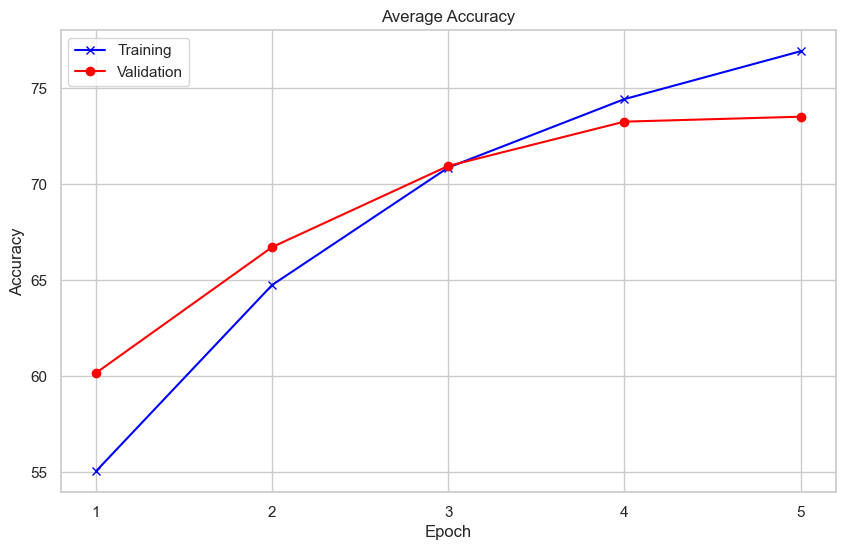

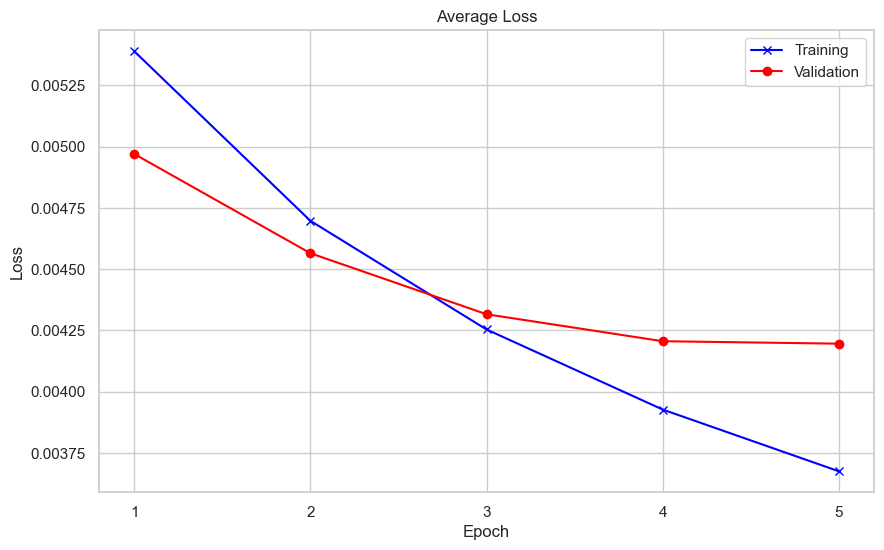

2260502 weights.
721 biases.
2261223 trainable parameters, (weights + biases).


In [32]:
display.plot_metrics(t_acc, v_acc, 'Accuracy')
display.plot_metrics(t_loss, v_loss, 'Loss')

In [ ]:
def save_model(model, model_optimizer):
    """
    Saves the model and optimizer state dictionaries.
    The model `state_dict` contains all learnable parameters of the model.
    The optimizer `state_dict` contains information about the optimizer.
        This allows the model to pause and resume training.
    Args:
        model (nn.Module): The LSTM model being loaded.
        model_optimizer (torch.optim.Adam): Backpropagation method.
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': model_optimizer.state_dict(),
    }, 'checkpoint.pth')

save_model(loaded_model, optimizer)